In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pandas_datareader as web
import talib
import seaborn as sns
import gym
from gym import spaces
from gym.utils import seeding
import enum
import pyfolio as pf
import matplotlib.pyplot as plt
import pickle
import os
import random
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

C:\Users\User\anaconda3\envs\MyDjango\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


Stock name: TM
Start: 2013-02-19 00:00:00, End: 2020-12-31 00:00:00
Training data: 1227 
Testing data: 756 


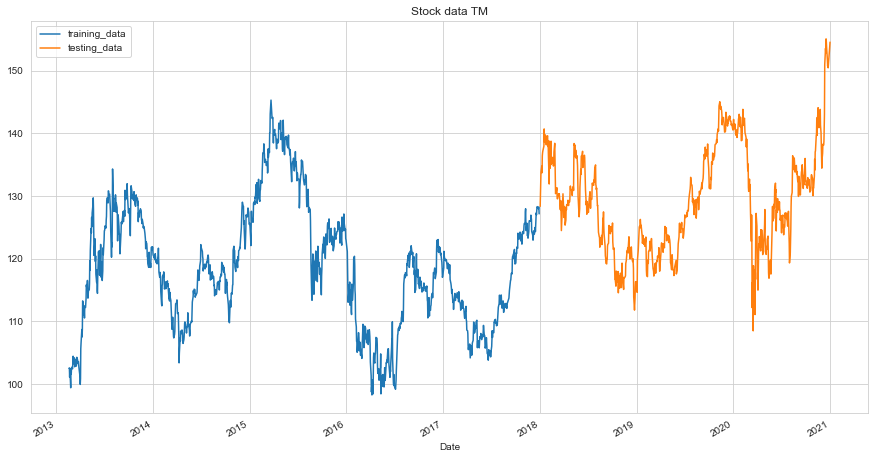

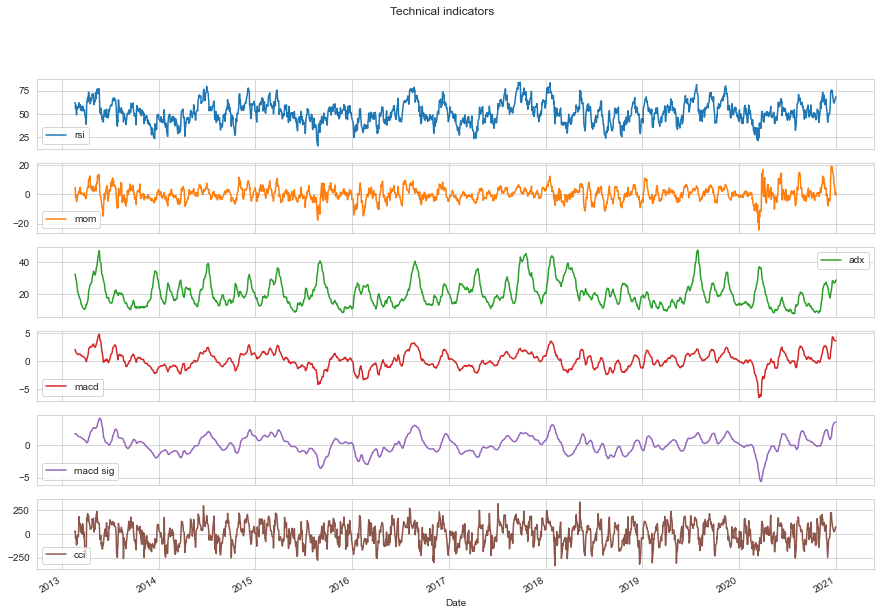

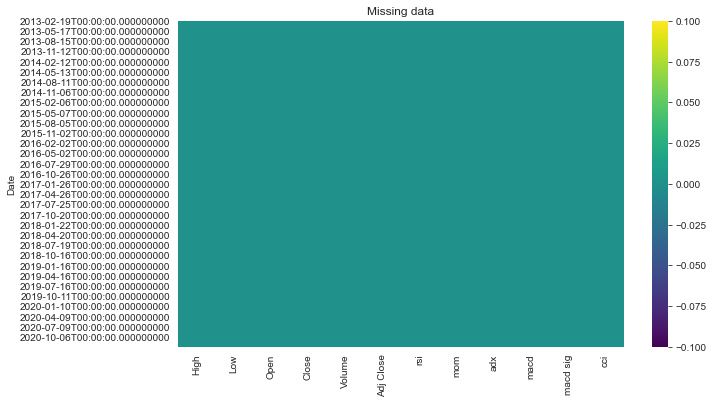

,High,Low,Open,Close,Volume,Adj Close,rsi,mom,adx,macd,macd sig,cci
Date,,,,,,,,,,,,
2013-02-19,102.690002,101.599998,101.769997,102.519997,753100.0,102.519997,61.958114,4.689995,32.652716,2.090214,1.745447,21.305568
2013-02-20,103.989998,102.540001,103.790001,102.589996,602100.0,102.589996,62.147503,3.729996,32.564830,2.006615,1.797680,32.473950
2013-02-21,101.910004,100.330002,101.760002,101.099998,608600.0,101.099998,55.781609,-1.700005,31.143030,1.799389,1.798022,-40.605106
2013-02-22,102.339996,101.459999,102.029999,102.339996,694400.0,102.339996,59.499653,-0.460007,30.003989,1.715444,1.781506,-22.261300
2013-02-25,102.480003,99.339996,102.129997,99.419998,697300.0,99.419998,49.042162,-5.029999,27.874800,1.397192,1.704643,-116.576504


In [7]:
stock_name = 'tm'.upper()
stock_data = pd.read_csv(f'../train_test_data/{stock_name}.csv', index_col=['Date'], parse_dates=True)

train_data = stock_data.loc[:'2018-01-01']
test_data = stock_data.loc['2018-01-01':]


print(f'Stock name: {stock_name}')
print(f'Start: {stock_data.index[0]}, End: {stock_data.index[-1]}')
print(f'Training data: {len(train_data)} ')
print(f'Testing data: {len(test_data)} ')

sns.set_style('whitegrid')
train_data['Adj Close'].plot(label='training_data', figsize=(15,8));
test_data['Adj Close'].plot(label='testing_data');
plt.title('Stock data '+ stock_name)
plt.legend();
plt.show()

stock_data[['rsi', 'mom', 'adx', 'macd', 'macd sig', 'cci']].plot(subplots=True, figsize=(15,10), title='Technical indicators');
plt.show()


plt.figure(figsize=(10,6))
sns.heatmap(stock_data.isnull(), cmap='viridis');
plt.title('Missing data');
plt.show()
high = stock_data['Adj Close'].max()

stock_data.head()

In [8]:
     

class QAgent(object):
    
    
    def __init__(self, state_size, action_size, gamma=0.9, ticker=''):
        
        
        self.state_size = state_size
        self.action_size = action_size
        self.model = self.build_model_nn()
        self.gamma = gamma  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.ticker = ticker
        self.save_epsilon = []
    
    
    
    def seeding(self, seeds=101):
        return np.random.seed(seeds)
    
    
    
    def build_model_nn(self):
        
        class LinearModel:
            
            def __init__(self, input_dim, n_action):
                
                self.W = np.random.randn(input_dim, n_action) / np.sqrt(input_dim)
                self.b = np.zeros(n_action)
                self.vW = 0
                self.vb = 0
                self.losses = []
                

            def forward(self, s):
                return s.dot(self.W) + self.b
            

            def sgd(self, s, Y, learning_rate=0.01, momentum=0.9):
                num_values = np.prod(Y.shape)

                Y_hat = self.forward(s)  # shape (1, 8)
                gW = 2 * s.T.dot(Y_hat - Y) / num_values  # vector shape (7, 8)
                gb = 2 * (Y_hat - Y).sum(axis=0) / num_values  # scalar

                self.vW = momentum * self.vW - learning_rate * gW  # vector shape (7, 8)
                self.vb = momentum * self.vb - learning_rate * gb  # scalar

                self.W += self.vW  # vector shape (7, 8)
                self.b += self.vb  # scalar

                mse = np.mean((Y_hat - Y) ** 2)
                self.losses.append(mse)
        
        
        self.seeding()
        model = LinearModel(self.state_size, self.action_size)
        
        return model
    

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.forward(state)
        return np.argmax(act_values[0])  # returns action


    def train(self, state, action, reward, next_state, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.amax(self.model.forward(next_state), axis=1)

        target_full = self.model.forward(state)
        target_full[0, action] = target

        # Run one training step
        self.model.sgd(state, target_full)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        self.save_epsilon.append(self.epsilon)
        

    def load(self):
   
        npz = np.load(f'state_dict/{self.ticker}.npz')
        self.model.W = npz['W']
        self.model.b = npz['b']
        print('Loading complete!!')
        


    def save(self):
        
        np.savez(f'state_dict/{self.ticker}.npz', W=self.model.W, b=self.model.b)
        
        print('Save!!')
    

In [9]:
# environment

class Actions(enum.Enum):
    Sell = 0
    Buy = 1
    Hold = 2


class Positions(enum.Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long
    


class SingleStockEnv(gym.Env):
    '''
    Single Stock for trading

    '''
    
    metadata = {'render.modes': ['human']}

    def __init__(self, data, capital, trade_fee_bid_percent = 0.01, trade_fee_ask_percent = 0.005):
        
        self.trade_fee_bid_percent = trade_fee_bid_percent/100  # percent
        self.trade_fee_ask_percent = trade_fee_ask_percent/100  # percent
        self.stock_price_history = data
        self.n_step = self.stock_price_history.shape[0]
        self.capital = capital
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None
        self.state_dim = 9  # [stock price, stock_owned, cash_in_hand, rsi, mom, adx, macd, macd_sig, cci]
        self.save_position = []
        self.save_port_val = []
        self.save_cash = []
        self.total_reward = None
        self.stock_value = []
        self.sell_buy = None
        self.save_stock_price = []
        
        # space
        self.action_space = spaces.Discrete(len(Actions)) # 0, 1, 2
        
        # episode
        self.start_tick = 0
        self.end_tick = self.n_step - 1
        self.current_tick = None
        self.done = None
        self._position = None
        self._position_history = None
        self.save_reward = []
        self.rsi = None
        self.mom = None
        self.adx = None
        self.macd = None
        self.masc_sig = None
        self.cci = None
        
        self.reset()
        

        
        
    def reset(self):
        self.done = False
        self.current_tick = self.start_tick = 0
        self.stock_owned = 0.
        self.stock_price = self.stock_price_history['Adj Close'][self.current_tick]
        self.cash_in_hand = self.capital
        self.save_position = [0]
        self.save_port_val = [self.capital]
        self.save_cash = [self.capital]
        self.total_reward = [0]
        self.stock_value = [0]
        self.sell_buy = ['hold']
        self._position = Positions.Short
        self._position_history = [self._position]
        self.save_stock_price = [self.stock_price]
        self.rsi = self.stock_price_history['rsi'][self.current_tick]
        self.mom = self.stock_price_history['mom'][self.current_tick]
        self.adx = self.stock_price_history['adx'][self.current_tick]
        self.macd = self.stock_price_history['macd'][self.current_tick]
        self.masc_sig = self.stock_price_history['macd sig'][self.current_tick]
        self.cci = self.stock_price_history['cci'][self.current_tick]
        return self.state_vector()
        

    def state_vector(self):
        vector = np.empty(self.state_dim)
        vector[0] = self.stock_price
        vector[1] = self.stock_owned
        vector[2] = self.cash_in_hand
        vector[3] = self.rsi
        vector[4] = self.mom
        vector[5] = self.adx
        vector[6] = self.macd
        vector[7] = self.masc_sig
        vector[8] = self.cci
        return vector


    def port_val(self):
        return (self.stock_owned * self.stock_price) + self.cash_in_hand
    

    def trade(self, action):
            
        if (action == Actions.Sell.value and self._position == Positions.Long):
            # sell
            self.cash_in_hand += ((self.stock_owned * self.stock_price) * (1 - self.trade_fee_bid_percent))
            self.stock_owned -= self.stock_owned
            self.sell_buy.append('sell')

        elif (action == Actions.Buy.value and self._position == Positions.Short):            
            # buy
            self.stock_owned += ((self.cash_in_hand * (1 - self.trade_fee_ask_percent)) / self.stock_price)
            self.cash_in_hand -= ((self.cash_in_hand / self.stock_price) * self.stock_price)
            self.sell_buy.append('buy')

            
    def step(self, action):

        prev_port_val = self.port_val()
        self.current_tick += 1
        
        if self.current_tick == self.end_tick:
            self.done = True
            

        
        self.stock_price = self.stock_price_history['Adj Close'][self.current_tick]
        self.rsi = self.stock_price_history['rsi'][self.current_tick]
        self.mom = self.stock_price_history['mom'][self.current_tick]
        self.adx = self.stock_price_history['adx'][self.current_tick]
        self.macd = self.stock_price_history['macd'][self.current_tick]
        self.masc_sig = self.stock_price_history['macd sig'][self.current_tick]
        self.cci = self.stock_price_history['cci'][self.current_tick]
        
        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True
            
        if trade:
            self.trade(action)
            self._position = self._position.opposite()
            
        else:
            self.sell_buy.append('hold')
            
        self._position_history.append(self._position)
            
        current_port_val = self.port_val()
        step_reward = current_port_val - prev_port_val
        self.total_reward.append(step_reward)
        self.save_reward.append(step_reward)
        self.save_cash.append(self.cash_in_hand)
        self.save_port_val.append(self.port_val())
        self.save_position.append(self.stock_owned)
        self.stock_value.append(self.stock_owned * self.stock_price)
        self.save_stock_price.append(self.stock_price)
        
        
        info = {'stock_price': self.save_stock_price,
                'portfolio_value': self.save_port_val,
                'current_val': self.total_reward,
                'stock_owned': self.save_position,
                'cash_in_hand': self.save_cash,
                'stock_value': self.stock_value,
                'sell_buy': self.sell_buy,
                }
        return self.state_vector(), step_reward, self.done, info
    
    
    def get_scaler(self):
        states = []
        self.reset()
        for i in range(self.n_step):
            action = self.action_space.sample()
            state, reward, done, info = self.step(action)
            states.append(state)
            if done:
                break
        scaler = StandardScaler()
        scaler.fit(states)
        return scaler

        

In [10]:
num_episodes = 2000

capital = 1000
train_env = SingleStockEnv(data=train_data,
                           capital=capital)
state_size = train_env.state_dim
nb_action = 2
agent = QAgent(state_size,
               nb_action,
               gamma=0.9,
               ticker=stock_name)
scaler = train_env.get_scaler()

Training Model


  0%|          | 0/2000 [00:00<?, ?it/s]

Episode:    1/2000
Begin portfolio value:  1000.00
End portfolio value:     784.32
Since: 1227 days
Return -21.57 %
Epsilon: 0.00999
Sell: 225, Buy: 226
Cumulative Reward:  -215.68
Mean Squared Error Loss:  13.5258

Episode:  100/2000
Begin portfolio value:  1000.00
End portfolio value:     722.69
Since: 1227 days
Return -27.73 %
Epsilon: 0.00999
Sell: 427, Buy: 427
Cumulative Reward:  4774.34
Mean Squared Error Loss: 269.9986

Episode:  200/2000
Begin portfolio value:  1000.00
End portfolio value:    1080.19
Since: 1227 days
Return 8.02 %
Epsilon: 0.00999
Sell: 336, Buy: 337
Cumulative Reward:  8861.06
Mean Squared Error Loss:  50.8694

Episode:  300/2000
Begin portfolio value:  1000.00
End portfolio value:     789.71
Since: 1227 days
Return -21.03 %
Epsilon: 0.00999
Sell: 323, Buy: 323
Cumulative Reward: 13202.98
Mean Squared Error Loss:   7.6290

Episode:  400/2000
Begin portfolio value:  1000.00
End portfolio value:     694.98
Since: 1227 days
Return -30.50 %
Epsilon: 0.00999
Sell:

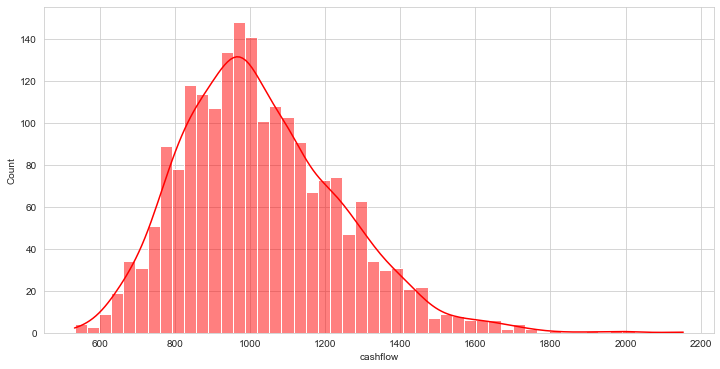

In [11]:
print('Training Model')
portfolio_value = []
total_reward = []

with open(f'scaler/{stock_name}.pkl', 'wb') as f:
    pickle.dump(scaler, f)

for e in tqdm(range(num_episodes)):
    
    state = train_env.reset()
    state = scaler.transform([state])
    done = False
    step_reward = 0
    history_reward = []
    

    while not done:
        action = agent.act(state)
        next_state, last_reward, done, info = train_env.step(action)
        next_state = scaler.transform([next_state])
        agent.train(state, action, last_reward, next_state, done)
        step_reward += last_reward
        state = next_state
        history_reward.append(last_reward)
        
    total_reward.append(step_reward)
        
    
    if (e+1) % (num_episodes/20) == 0 or (e+1 == 1):     
        print(f"Episode: {e + 1:4}/{num_episodes}")
        print(f"Begin portfolio value: {capital:8.2f}")
        print(f"End portfolio value: {info['portfolio_value'][-1]:10.2f}")
        print(f'Since: {len(train_data)} days')
        print(f"Return {(info['portfolio_value'][-1] - capital) * 100/capital:.2f} %")
        print(f"Epsilon: {agent.epsilon:2.5f}")
        print(f"Sell: {train_env.sell_buy.count('sell')}, Buy: {train_env.sell_buy.count('buy')}")
        print(f'Cumulative Reward: {sum(total_reward):8.2f}')
        print(f"Mean Squared Error Loss: {agent.model.losses[-1]:8.4f}")
        print('=======================================================================')
        print()
    
    portfolio_value.append(info['portfolio_value'][-1]) 



agent.save()
losses = agent.model.losses

print(f'average reward: {np.mean(portfolio_value):.2f}, min: {np.min(portfolio_value):.2f}, max: {np.max(portfolio_value):.2f}')
plt.figure(figsize=(12,6))
sns.histplot(portfolio_value, bins=50, color='r', kde=True);
plt.xlabel('cashflow');
plt.ylabel('Count');

Loading complete!!
Testing Model



Start: 2018-01-02 00:00:00  End: 2020-12-31 00:00:00
Since: 756 days
Begin portfolio value:  1000.00
End portfolio value:    1000.00
Return 0.00 %
Sell: 0 times, Buy: 0 times


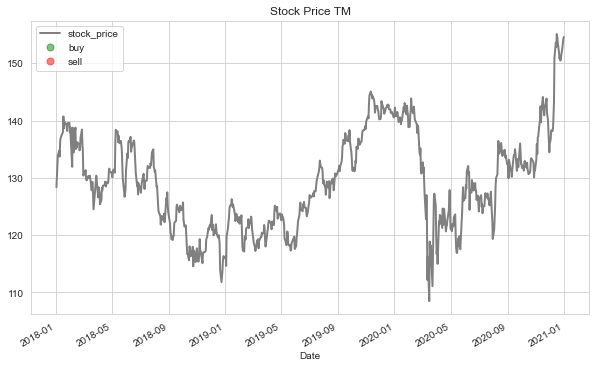

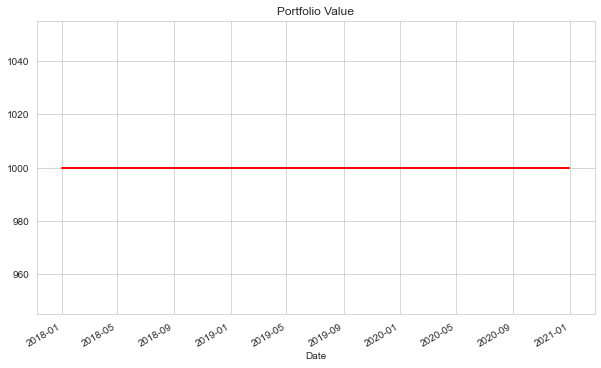

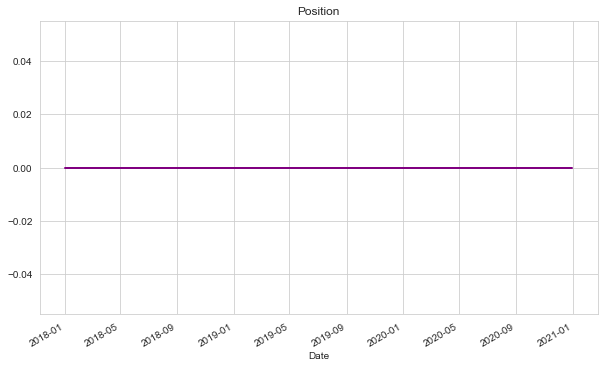

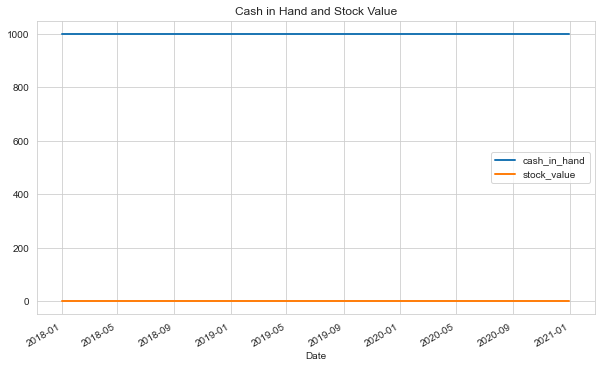

In [13]:
test_env = SingleStockEnv(test_data,
                             capital)
state_size = test_env.state_dim
nb_action = 2
agent = QAgent(state_size, nb_action, 0.9, ticker=stock_name)
with open(f'scaler/{stock_name}.pkl', 'rb') as f:
    scaler = pickle.load(f)


state = test_env.reset()
state = scaler.transform([state])
last_reward = 0
done = False
agent.load()
agent.epsilon = 0

while not done:
    action = agent.act(state)
    next_state, reward, done, info = test_env.step(action)
    next_state = scaler.transform([next_state])
    state = next_state


print('Testing Model')
print('=======================================================================')
print('=======================================================================')
print()
print()
print()
print(f'Start: {test_data.index[0]}  End: {test_data.index[-1]}')
print(f'Since: {len(test_data)} days')
print(f"Begin portfolio value: {capital:8.2f}")
print(f"End portfolio value: {info['portfolio_value'][-1]:10.2f}")
print(f"Return {(info['portfolio_value'][-1] - capital) * 100/capital:.2f} %")
print(f"Sell: {test_env.sell_buy.count('sell')} times, Buy: {test_env.sell_buy.count('buy')} times")
print('=======================================================================')

result = pd.DataFrame(info)
result.index = test_data.index

def marker_buy(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'buy':
        return price
    else:
        return np.nan
    
def marker_sell(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'sell':
        return price
    else:
        return np.nan
    
result['marker_buy'] = result[['stock_price', 'sell_buy']].apply(marker_buy, axis=1);
result['marker_sell'] = result[['stock_price', 'sell_buy']].apply(marker_sell, axis=1);

result['stock_price'].plot(figsize=(10,6), c='grey', lw=2);
result['marker_buy'].plot(style='o', ms=7, label='buy', c='g', alpha=0.5);
result['marker_sell'].plot(style='o', ms=7, label='sell', c='r', alpha=0.5);
plt.title('Stock Price '+ stock_name)
plt.legend();
plt.show()



result['portfolio_value'].plot(figsize=(10,6), c='r', lw=2);
plt.title('Portfolio Value');
plt.show()

result['stock_owned'].plot(figsize=(10,6), c='purple', lw=2);
plt.title('Position')
plt.show()

result[['cash_in_hand', 'stock_value']].plot(figsize=(10,6), lw=2);
plt.title('Cash in Hand and Stock Value');
plt.show()

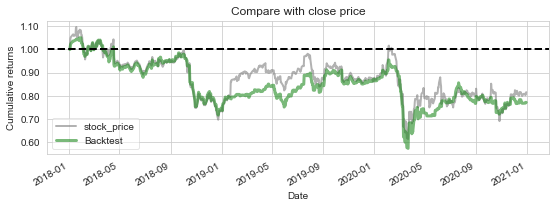

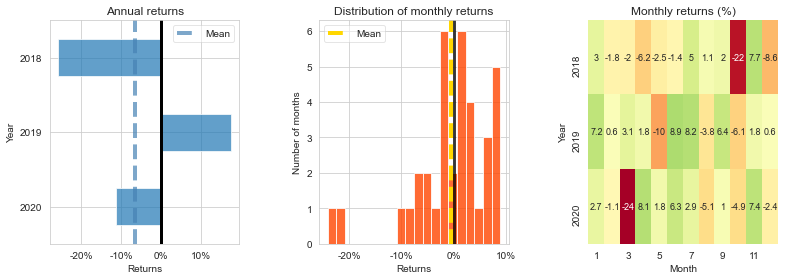

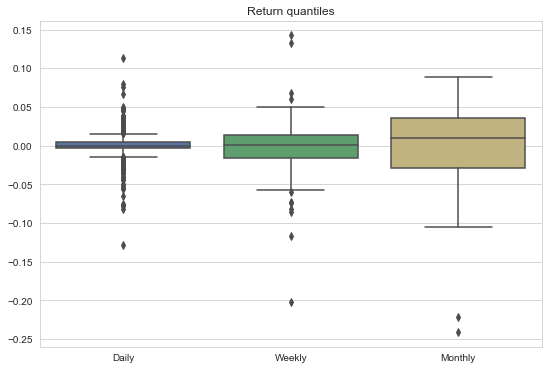

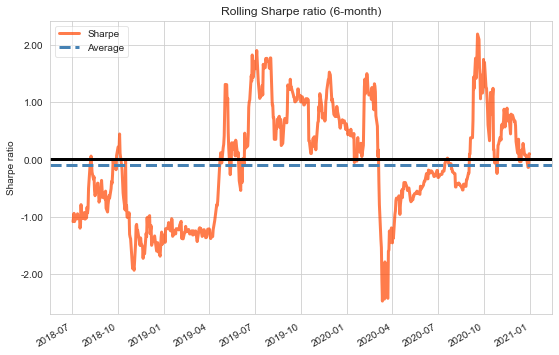

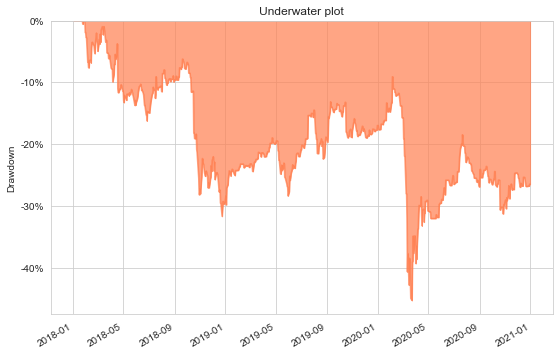

In [9]:
bt_returns = result['portfolio_value'].pct_change()
price = result['stock_price'].pct_change()



plt.figure(figsize=(9,6));
plt.subplot(2,1,1);
pf.plotting.plot_rolling_returns(bt_returns, price);
plt.title('Compare with close price');
plt.show()

fig = plt.figure(1)
plt.subplot(1,3,1)
pf.plot_annual_returns(bt_returns)
plt.subplot(1,3,2)
pf.plot_monthly_returns_dist(bt_returns)
plt.subplot(1,3,3)
pf.plot_monthly_returns_heatmap(bt_returns)
plt.tight_layout()
fig.set_size_inches(12,4)

plt.figure(figsize=(9,6))
pf.plot_return_quantiles(bt_returns);



plt.figure(figsize=(9,6))
pf.plot_rolling_sharpe(bt_returns);

plt.figure(figsize=(9,6))
pf.plot_drawdown_underwater(bt_returns);